In [5]:
# from pyscf import gto, scf, cc, fci
import numpy as np
import matplotlib.pyplot as plt

In [72]:
def rot_z(array,theta):
    x = np.cos(theta)*array[0]-np.sin(theta)*array[1]
    y = np.sin(theta)*array[0]+np.cos(theta)*array[1]
    return np.round(np.array([x,y,0]),6)

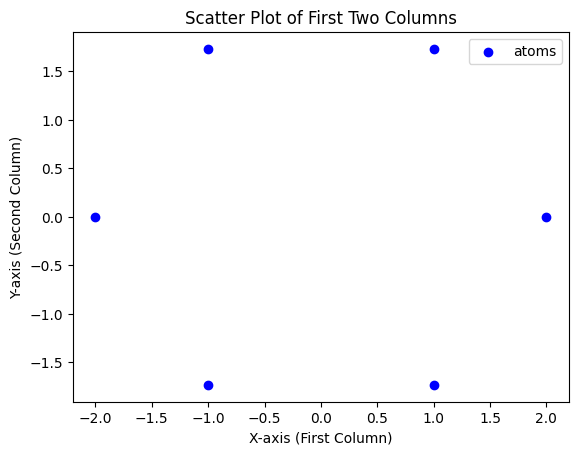

In [73]:
a = np.empty((6,3))
a0 = [2,0,0]
a[0] = a0
# print(a[0])
for i in range(5):
    a[i+1] = rot_z(a[i],2*np.pi/6)

x = a[:, 0]
y = a[:, 1] 

plt.scatter(x, y, color='blue', marker='o', label="atoms")
plt.xlabel("X-axis (First Column)")
plt.ylabel("Y-axis (Second Column)")
plt.title("Scatter Plot of First Two Columns")
plt.legend()
plt.show()

In [74]:
atoms = [["H"]]*6
xyz = np.hstack((atoms,a))
xyz_str = ""
for atom,x,y,z in xyz:
    xyz_str += "".join(f"{atom} \t {x} \t {y} \t {z} \n")

print(xyz_str)

H 	 2.0 	 0.0 	 0.0 
H 	 1.0 	 1.732051 	 0.0 
H 	 -1.0 	 1.732051 	 0.0 
H 	 -2.0 	 0.0 	 0.0 
H 	 -1.0 	 -1.732051 	 0.0 
H 	 1.0 	 -1.732051 	 0.0 



In [75]:
basis = 'sto6g'
verbose = 4
memory = 20000
a = 0.7

# atom = f'''
# H 0 0 0
# H {a} 0 0
# H {a} {a} 0
# H 0 {a} 0
# '''

mol = gto.Mole(
verbose=verbose,
atom=xyz_str,
basis=basis,
max_memory=memory
)
mol.build()

# RHF
mf = scf.RHF(mol).density_fit()
mf = mf.newton()
mf.kernel()

### coupled cluster ###
mc = cc.CCSD(mf)
mc.kernel()
et = mc.ccsd_t()

## fci
fci = fci.FCI(mf)
fci_e, fci_v = fci.kernel()

print(f"rhf energy is {mf.e_tot}")
print(f"ccsd energy is {mc.e_tot}")
print(f"ccsd(t) energy is {mc.e_tot+et}")
print(f"fci energy is {fci.e_tot}")

from mpi4py import MPI
MPI.Finalize() ### finalize MPI after ccsd
from ad_afqmc import pyscf_interface

mo_file="mo.npz"
chol_file="chol"
amp_file="amp.npz"
pyscf_interface.prep_afqmc(mc,mo_file=mo_file,amp_file=amp_file,chol_file=chol_file)

System: uname_result(system='Linux', node='yichi-thinkpad', release='4.4.0-26100-Microsoft', version='#1882-Microsoft Fri Jan 01 08:00:00 PST 2016', machine='x86_64')  Threads 12
Python 3.10.16 | packaged by conda-forge | (main, Dec  5 2024, 14:16:10) [GCC 13.3.0]
numpy 1.24.3  scipy 1.14.1  h5py 3.12.1
Date: Sat Feb  1 11:55:25 2025
PySCF version 2.7.0
PySCF path  /home/yichi/research/software/pyscf
GIT HEAD (branch master) a0665c4a7bf54e33f01295b3eea390be7a17d76d

[ENV] PYSCF_EXT_PATH /home/yichi/research/software/pyscf
[CONFIG] conf_file None
[INPUT] verbose = 4
[INPUT] num. atoms = 6
[INPUT] num. electrons = 6
[INPUT] charge = 0
[INPUT] spin (= nelec alpha-beta = 2S) = 0
[INPUT] symmetry False subgroup None
[INPUT] Mole.unit = angstrom
[INPUT] Symbol           X                Y                Z      unit          X                Y                Z       unit  Magmom
[INPUT]  1 H      2.000000000000   0.000000000000   0.000000000000 AA    3.779452249130   0.000000000000   0.000000

In [2]:
# rhf energy is -2.4432366715273153
# ccsd energy is -3.0578601545796626
# ccsd(t) energy is -3.063664444020782
# fci energy is -2.878431523258702
en_rhf = -2.4432366715273153
en_ccsd = -3.0578601545796626
en_ccsd_t = -3.063664444020782
en_fci = -2.878431523258702

In [3]:
from ad_afqmc.corr_sample_test import corr_sample
from ad_afqmc import mpi_jax, config
import time
from functools import partial
from jax import random

# Hostname: yichi-thinkpad
# System Type: Linux
# Machine Type: x86_64
# Processor: x86_64


In [34]:
options = {
    "dt": 0.01,
    "n_exp_terms": 6,
    "n_walkers": 50,
    "n_runs": 10,
    "rlx_steps": 0,
    "prop_steps": 10,
    "seed": 2,
    "walker_type": "rhf",
    "trial": "cisd",
    "use_gpu": False,
    "free_proj": False,
}

nwalkers = options["n_walkers"]
dt = options["dt"]
seed = options["seed"]
rlx_steps = options["rlx_steps"]
prop_steps = options["prop_steps"]
n_runs = options["n_runs"]

mo_file="mo.npz"
chol_file="chol"
amp_file="amp.npz"

In [35]:
config.setup_jax()
MPI = config.setup_comm()

init_time = time.time()
comm = MPI.COMM_WORLD
rank = comm.Get_rank()  # Process rank
size = comm.Get_size()  # Total number of processes

ham_data, ham, prop, trial, wave_data, sampler, observable, options, _ \
    = mpi_jax._prep_afqmc(options,mo_file=mo_file,amp_file=amp_file,chol_file=chol_file)

prop_data_init, ham_data_init = \
    corr_sample.init_prop(ham_data, ham, prop, trial, wave_data, seed, MPI)


if options["trial"] == "rhf":
    print(f'# relaxation from mean-field object using {nwalkers*size} walkers')
if options["trial"] == "cisd":
    print(f'# relaxation from ccsd object using {nwalkers*size} walkers')
print('# rlx_step \t energy ')
print(f'    {0}  \t \t {prop_data_init["e_estimate"]:.6f}')

# Hostname: yichi-thinkpad
# System Type: Linux
# Machine Type: x86_64
# Processor: x86_64
# Number of MPI ranks: 1
#
# norb: 6
# nelec: (3, 3)
#
# dt: 0.01
# n_exp_terms: 6
# n_walkers: 50
# n_runs: 10
# rlx_steps: 0
# prop_steps: 10
# seed: 2
# walker_type: rhf
# trial: cisd
# use_gpu: False
# free_proj: False
# n_prop_steps: 50
# n_ene_blocks: 50
# n_sr_blocks: 1
# n_blocks: 50
# n_eql: 1
# orbital_rotation: True
# do_sr: True
# symmetry: False
# save_walkers: False
# ene0: 0.0
# free_projection: False
# n_batch: 1
# LNO: False
# orbE: 0
# maxError: 0.001
#
# relaxation from ccsd object using 50 walkers
# rlx_step 	 energy 
    0  	 	 -3.057860


In [23]:
from ad_afqmc.propagation import propagator
from ad_afqmc.wavefunctions import wave_function
from ad_afqmc import sampling
import jax
from jax import numpy as jnp
sampler_eq = sampling.sampler(n_prop_steps=50, n_ene_blocks=5, n_sr_blocks=10)
field_block_scan = corr_sample.field_block_scan
en_samples = corr_sample.en_samples

def otler_rm(prop_data, z_thresh = 5):
    wt = jnp.array(prop_data["weights"])
    wt_mean = jnp.mean(wt)
    wt_std = jnp.std(wt)
    wt_z = jnp.abs(wt-wt_mean)/wt_std
    prop_data["weights"] = jnp.array(jnp.where(wt_z > z_thresh, 0.0, wt))
    return prop_data

def one_step(
        prop_data: dict,
        ham_data: dict,
        prop: propagator,
        trial: wave_function,
        wave_data: dict):
    '''correlated sampling of two blocks of walkers over the same field'''
    prop_data["key"], subkey = random.split(prop_data["key"])
    fields = random.normal(
        subkey,
        shape=(
            sampler_eq.n_prop_steps,
            prop.n_walkers,
            ham_data["chol"].shape[0],
        )
    )
    prop_data = field_block_scan(prop_data,fields,ham_data,prop,trial,wave_data)
    prop_data= otler_rm(prop_data,z_thresh=5)

    return prop_data

def steps_scan(steps,prop_data,ham_data,prop,trial,wave_data):

    def _steps(prop_data,_):
        prop_data = one_step(prop_data,ham_data,prop,trial,wave_data)
        loc_en_samples = en_samples(prop_data,ham_data,prop,trial,wave_data)
        loc_weight_sample = prop_data["weights"]
        loc_weight = sum(loc_weight_sample)
        loc_en_sample = loc_en_samples*loc_weight_sample
        loc_en = sum(loc_en_sample) #not normalized
        return prop_data, (loc_en,loc_weight)

    prop_data, (loc_en,loc_weight) \
        = jax.lax.scan(_steps,prop_data,xs=None,length=steps)
    return prop_data, (loc_en,loc_weight)

def scan_seeds(seeds,steps,
               prop_data_init,ham_data_init,prop,trial,wave_data, 
               MPI):

    comm = MPI.COMM_WORLD
    rank = comm.Get_rank()

    def _seeds(carry,seed):
        prop_data_init["key"] = jax.random.PRNGKey(seed + rank)
        _,(loc_en,loc_weight) \
            = steps_scan(steps,prop_data_init,ham_data_init,prop,trial,wave_data)
        
        return carry, (loc_en,loc_weight)
    
    _, (loc_en,loc_weight) = jax.lax.scan(_seeds, None, seeds)

    return loc_en,loc_weight

In [24]:
nsteps = 5
prop_data_rlx,(loc_en,loc_weight) = steps_scan(nsteps,prop_data_init,ham_data_init,prop,trial,wave_data)

In [25]:
print(prop_data_rlx["weights"])

[0.90647079 1.0951683  0.90353566 1.14920945 1.10504263 0.86113798
 0.93567071 0.82792429 1.06063059 0.93821274 0.77999637 0.97356933
 0.89336923 1.05243947 1.18666565 0.67428659 1.22999939 0.76163352
 0.97720652 0.89156873 1.18141612 0.92558797 0.96780659 1.00712882
 1.03331784 0.98000358 0.84472029 1.06224761 0.93345338 0.83698264
 1.08520137 1.07299298 0.93204497 1.00984573 1.50793669 1.07916024
 0.71144635 1.07856337 0.93120959 0.924335   1.05215652 1.07963005
 0.99102176 0.89899904 0.98434519 1.03569295 0.84729269 0.7811693
 0.94597415 1.10924364]


In [68]:
print(loc_en)
print(loc_weight)
print(loc_en/loc_weight)

[-148.26678502 -148.58664874 -148.79660534 -149.01266632 -148.66967448]
[50.23133754 50.25434936 50.13493224 50.25106948 50.18052458]
[-2.95167902 -2.95669232 -2.96792274 -2.96536308 -2.9626967 ]


In [46]:
print(prop_data_init["e_estimate"])
energy = np.hstack((prop_data_init["e_estimate"],loc_en/loc_weight))
print(energy)


-1.9435765482220617
[-1.94357655 -1.94148724 -1.9405467  -1.93946268 -1.9373742  -1.93763711
 -1.93588008 -1.93998978 -1.9417205  -1.94094693 -1.9399649 ]


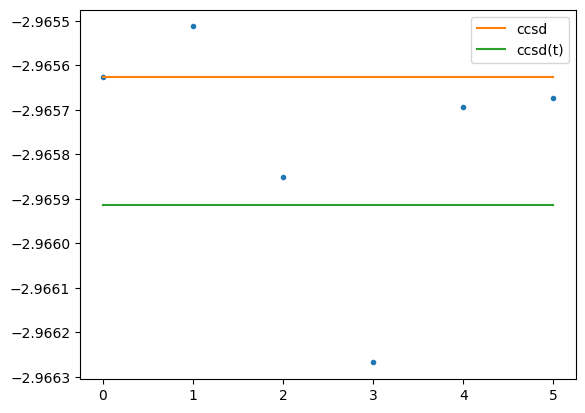

In [8]:
from matplotlib import pyplot as plt
energy = np.hstack((prop_data_init["e_estimate"],loc_en/loc_weight))
plt.plot(np.arange(nsteps+1),energy,'.')
plt.plot(np.linspace(0,nsteps,100),[en_ccsd]*100,label='ccsd')
plt.plot(np.linspace(0,nsteps,100),[en_ccsd_t]*100,label='ccsd(t)')
# plt.plot(np.linspace(0,nsteps,100),[en_fci]*100,label='fci')
plt.legend()
plt.show()

In [36]:
n_runs = 30
n_steps = 10
seeds = random.randint(random.PRNGKey(options["seed"]),
                    shape=(n_runs,), minval=0, maxval=100000*n_runs)

loc_en,loc_wt = scan_seeds(seeds,n_steps,prop_data_init,ham_data_init,prop,trial,wave_data,MPI)

In [19]:
# print(loc_en)
# print(loc_wt)
print(loc_en/loc_wt)

[[-2.965507  -2.9658222 -2.966141 ]
 [-2.9656942 -2.9656048 -2.9655209]
 [-2.9658077 -2.9657109 -2.9658363]
 [-2.9655442 -2.9659784 -2.9657629]
 [-2.9656754 -2.9655297 -2.965623 ]
 [-2.965566  -2.9657822 -2.965666 ]
 [-2.965607  -2.9657924 -2.9656143]
 [-2.965564  -2.9655719 -2.9659543]
 [-2.9657063 -2.9657884 -2.9661946]
 [-2.9664624 -2.966357  -2.9663205]
 [-2.9654746 -2.965726  -2.9658515]
 [-2.965622  -2.9656644 -2.9658113]
 [-2.965599  -2.965958  -2.9662592]
 [-2.9655576 -2.9659464 -2.966061 ]
 [-2.9655724 -2.9657083 -2.965684 ]
 [-2.9655375 -2.9664855 -2.9662325]
 [-2.965856  -2.9655528 -2.9657352]
 [-2.9657006 -2.9655163 -2.9656968]
 [-2.9656827 -2.9660704 -2.9655712]
 [-2.9656034 -2.9658256 -2.965711 ]
 [-2.9656003 -2.9655437 -2.9655445]
 [-2.9656858 -2.9656777 -2.9659371]
 [-2.965808  -2.966319  -2.966148 ]
 [-2.965705  -2.966466  -2.9672651]
 [-2.9656057 -2.9656062 -2.9658654]
 [-2.9655952 -2.9655795 -2.9656618]
 [-2.9656014 -2.9655964 -2.9656382]
 [-2.965809  -2.9656012 -2.9

In [37]:
print('# step \t energy \t error')
print(f'  {0} \t {prop_data_init["e_estimate"]:.6f} \t {0:.6f}')

if rank == 0:
    glb_en = np.empty(size*loc_en.size,dtype='float32')
    glb_wt = np.empty(size*loc_wt.size,dtype='float32')
else:
    glb_en = None
    glb_wt = None


loc_en = np.asarray(loc_en,dtype='float32')
loc_wt = np.asarray(loc_wt,dtype='float32')

comm.Gather(loc_en,glb_en,root=0)
comm.Gather(loc_wt,glb_wt,root=0)


if rank == 0:
    glb_en = glb_en.reshape(size,n_runs,n_steps).T
    glb_wt = glb_wt.reshape(size,n_runs,n_steps).T

    energy = np.zeros((n_steps,n_runs))

    for step in range(n_steps):

        for run in range(n_runs):
            energy[step,run] = sum(glb_en[step,run,:])/sum(glb_wt[step,run,:])

        en_mean = energy[step,:].mean()
        en_err = energy[step,:].std()/np.sqrt(n_runs)
        print(f'  {step+1} \t {en_mean:.6f} \t {en_err:.6f}')



# step 	 energy 	 error
  0 	 -3.057860 	 0.000000
  1 	 -2.950466 	 0.001158
  2 	 -2.906489 	 0.001515
  3 	 -2.884347 	 0.002330
  4 	 -2.873604 	 0.002625
  5 	 -2.868248 	 0.002765
  6 	 -2.870969 	 0.003148
  7 	 -2.861980 	 0.002869
  8 	 -2.865732 	 0.004037
  9 	 -2.862182 	 0.003517
  10 	 -2.868982 	 0.005379


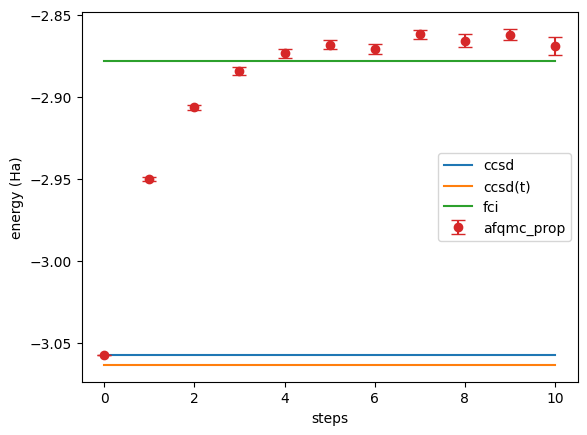

In [38]:
prop_data = '''
# step 	 energy 	 error
  0 	 -3.057860 	 0.000000
  1 	 -2.950466 	 0.001158
  2 	 -2.906489 	 0.001515
  3 	 -2.884347 	 0.002330
  4 	 -2.873604 	 0.002625
  5 	 -2.868248 	 0.002765
  6 	 -2.870969 	 0.003148
  7 	 -2.861980 	 0.002869
  8 	 -2.865732 	 0.004037
  9 	 -2.862182 	 0.003517
  10 	 -2.868982 	 0.005379
'''

prop_en = []
prop_en_err = []
lines = prop_data.splitlines()
for line in lines:
    if not line.startswith("#"): 
        columns = line.split()
        if len(columns) > 1:
            prop_en.append(columns[1])
        if len(columns) > 2:
            prop_en_err.append(columns[2])

prop_en = np.array(prop_en,dtype='float32')
prop_en_err = np.array(prop_en_err,dtype='float32')
prop_steps = np.arange(len(prop_en))

x_steps = np.linspace(0,max(prop_steps),100)

# plt.plot(x_steps,[en_rhf]*100)
plt.plot(x_steps,[en_ccsd]*100,label='ccsd')
plt.plot(x_steps,[en_ccsd_t]*100,label='ccsd(t)')
plt.plot(x_steps,[en_fci]*100,label='fci')

plt.errorbar(prop_steps,prop_en,yerr=prop_en_err, fmt='o',capsize=5,label='afqmc_prop')
plt.xlabel('steps')
plt.ylabel('energy (Ha)')

plt.legend()
plt.show()

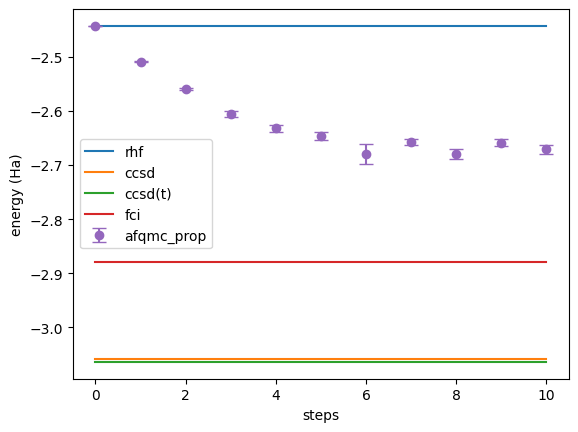

In [39]:
prop_data = '''
# step 	 energy 	 error
  0 	 -2.443237 	 0.000000
  1 	 -2.509332 	 0.001234
  2 	 -2.559376 	 0.002242
  3 	 -2.605948 	 0.005496
  4 	 -2.632290 	 0.006766
  5 	 -2.646442 	 0.006723
  6 	 -2.679891 	 0.017937
  7 	 -2.658361 	 0.005627
  8 	 -2.680358 	 0.008976
  9 	 -2.658615 	 0.006934
  10 	 -2.670605 	 0.008352
'''

prop_en = []
prop_en_err = []
lines = prop_data.splitlines()
for line in lines:
    if not line.startswith("#"): 
        columns = line.split()
        if len(columns) > 1:
            prop_en.append(columns[1])
        if len(columns) > 2:
            prop_en_err.append(columns[2])

prop_en = np.array(prop_en,dtype='float32')
prop_en_err = np.array(prop_en_err,dtype='float32')
prop_steps = np.arange(len(prop_en))

x_steps = np.linspace(0,max(prop_steps),100)

plt.plot(x_steps,[en_rhf]*100,label='rhf')
plt.plot(x_steps,[en_ccsd]*100,label='ccsd')
plt.plot(x_steps,[en_ccsd_t]*100,label='ccsd(t)')
plt.plot(x_steps,[en_fci]*100,label='fci')

plt.errorbar(prop_steps,prop_en,yerr=prop_en_err, fmt='o',capsize=5,label='afqmc_prop')
plt.xlabel('steps')
plt.ylabel('energy (Ha)')

plt.legend()
plt.show()